# Keypoint Estimation Models Analysis

In [66]:
import os
import sys
import math
import git
import cv2
import numpy as np
import torch
import lightning as L
import matplotlib.pyplot as plt

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(f"{git_root}/keypoint_estimation/")

## Loading data

In [24]:
from datamodule import KeypointEstDataModule

L.seed_everything(42, workers=True)

datamodule = KeypointEstDataModule(
    dataset_dir=os.path.join(
        os.path.expanduser("~"), "Documents/datasets"
    ),
    dataset_mode="ego4d",
    batch_size=1,
    transform_mode="display",
    selection="segsec",
    sample_num=16,
    neg_ratio=None,
    with_info=True,
)
datamodule.setup(stage="test")

iter_counter = 0
dataloader = iter(datamodule.test_dataloader())

Global seed set to 42


iter counter: 13
frames shape: torch.Size([1, 16, 3, 224, 224])
label shape: torch.Size([1, 16])
converted frames shape: (16, 224, 224, 3)
'nearest frame num' metalabel shape: torch.Size([1, 16])
info keys: dict_keys(['video_uid', 'parent_pnr_frame', 'parent_frame_num', 'segment_start_frame', 'segment_end_frame', 'nearest_pnr_diff', 'state_change', 'sample_frames', 'label_indicies', 'sample_pnr_diff'])


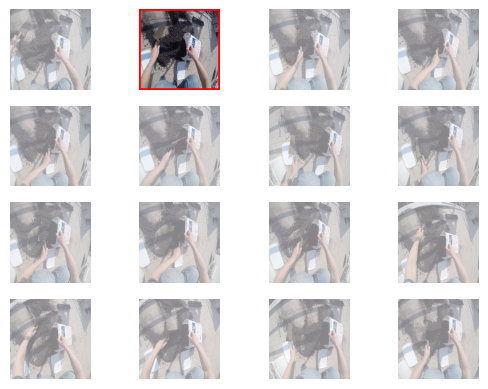

In [113]:
frames, labels, metalabel, [info] = next(dataloader)
iter_counter += 1

# convert torch.Size([b, frame_num, ch, w, h])
# to torch.Size([frame_num, w, h, ch])
# and to numpy array with type uint8
imgs = frames.permute(0,1,3,4,2).detach().numpy().copy()[0]

print(
    f"iter counter: {iter_counter}",
    f"frames shape: {frames.shape}",
    f"label shape: {labels.shape}",
    f"converted frames shape: {imgs.shape}",
    f"'nearest frame num' metalabel shape: {metalabel.shape}",
    f"info keys: {info.keys()}",
    sep="\n",
)

# visualize data
fig = plt.figure()
for i in range(len(imgs)):
    ax = fig.add_subplot(4, 4, 1+i)
    ax.axis("off")
    # ax.axes.get_xaxis().set_visible(False)
    # ax.axes.get_yaxis().set_visible(False)
    img = imgs[i]

    # add transparency
    w, h, _ = img.shape
    alpha = np.full((w,h,1), labels[0][i] * 0.5 + 0.5)
    img = np.dstack([img, alpha])

    # add red surrounding box
    # cv2.rectangle does not support image with (w,h,c,a)
    if labels[0][i] == 1:
        thickness = 5
        img[:thickness, :, :] = (1,0,0,1)
        img[-thickness:, :, :] = (1,0,0,1)
        img[:, :thickness, :] = (1,0,0,1)
        img[:, -thickness:, :] = (1,0,0,1)

    plt.imshow(img)

plt.show()

plt.clf()
plt.close()

## Model prediction

In [102]:
from system import KeypointEstModule

classifier = KeypointEstModule(
    model_name="vivit",
    frame_num=16,
    with_attention=True,
)

classifier.model.load_state_dict(
    torch.load(
        f"{git_root}/keypoint_estimation/logs/asyml/vivit.pth",
        map_location=torch.device("cpu"),
    ),
    strict=True,
)
classifier.eval()

KeypointEstModule(
  (model): ViViT(
    (vivit): VivitForVideoClassification(
      (vivit): VivitModel(
        (embeddings): VivitEmbeddings(
          (patch_embeddings): VivitTubeletEmbeddings(
            (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): VivitEncoder(
          (layer): ModuleList(
            (0-11): 12 x VivitLayer(
              (attention): VivitAttention(
                (attention): VivitSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): VivitSelfOutput(
                  (dense): Linear(in_features=768, out_features=768, bias=True)
           

preds: 
	tensor([[0.5169, 0.4962, 0.4906, 0.7138, 0.4403, 0.3996, 0.6329, 0.3748, 0.5140,
         0.4598, 0.5067, 0.6951, 0.4185, 0.1418, 0.3596, 0.7420]])
preds with threshold=0.5: 
	tensor([[1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.]])
GT labels: 
	tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
attention: 
	torch.Size([1, 12, 1569, 1569])


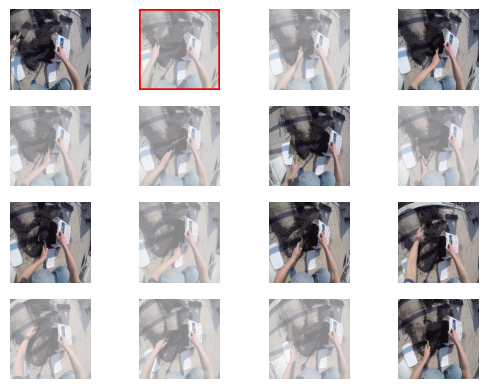

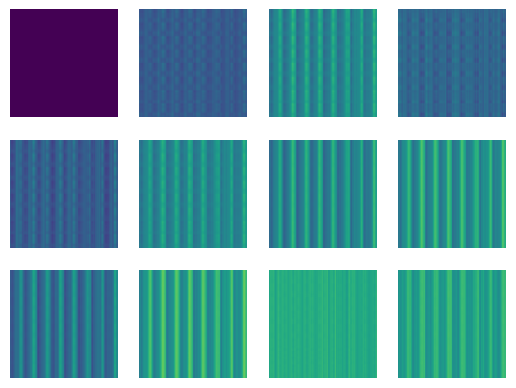

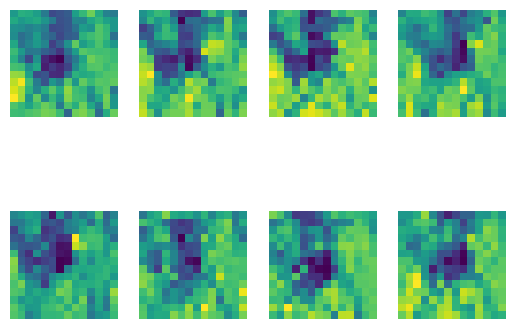

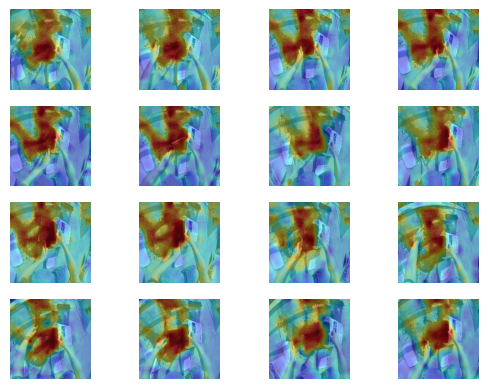

In [116]:
threshold = 0.5

with torch.no_grad():
    logits, attention = classifier(frames.float())
preds = logits.sigmoid()
output = (preds > threshold).float()

print(
    f"preds: \n\t{preds}",
    f"preds with threshold={threshold}: \n\t{output}",
    f"GT labels: \n\t{labels}",
    f"attention: \n\t{attention[0].shape}",
    sep="\n",
)

# visualize predictions
fig = plt.figure()
for i in range(len(imgs)):
    ax = fig.add_subplot(4, 4, 1+i)
    ax.axis("off")
    img = imgs[i]

    # add transparency
    w, h, _ = img.shape
    alpha = np.full((w,h,1), output[0][i] * 0.5 + 0.5)
    img = np.dstack([img, alpha])

    # add red surrounding box
    if labels[0][i] == 1:
        thickness = 5
        img[:thickness, :, :] = (1,0,0,1)
        img[-thickness:, :, :] = (1,0,0,1)
        img[:, :thickness, :] = (1,0,0,1)
        img[:, -thickness:, :] = (1,0,0,1)

    plt.imshow(img)

plt.show()

# visualize attention maps
fig = plt.figure()
for layer in range(len(attention)):
    ax = fig.add_subplot(3, 4, 1+layer)
    ax.axis("off")

    att = attention[layer].mean(dim=1).squeeze(0).detach().numpy().copy()
    plt.imshow(att)

plt.show()

# visualize class attention maps of last layer
cls_att = attention[-1][:,:,0,1:]
# average along all heads
cls_att = cls_att.mean(dim=1).squeeze(0).view(8,14,14).detach().numpy().copy()

fig = plt.figure()
for d in range(int(len(imgs)/2)):
    ax = fig.add_subplot(2, 4, 1+d)
    ax.axis("off")
    plt.imshow(cls_att[d])

plt.show()

# visualize class attention maps of last layer with input frames
fig = plt.figure()
for i in range(len(imgs)):
    ax = fig.add_subplot(4, 4, 1+i)
    ax.axis("off")
    img = imgs[i]

    cls_att_map = cv2.resize(cls_att[math.floor(i/2)], (224,224))
    # normalize to range 0~1
    map_min, map_max = np.min(cls_att_map), np.max(cls_att_map)
    norm_map = (cls_att_map - map_min)/(map_max - map_min)

    # create heatmap with jet colormap
    map_uint8 = (norm_map*255).astype(np.uint8)
    heatmap = cv2.applyColorMap(map_uint8, cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255

    alpha = 0.6
    plt.imshow(alpha * img + (1-alpha) * heatmap)

plt.show()

plt.clf()
plt.close()